In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from astropy.visualization import astropy_mpl_style
plt.style.use(astropy_mpl_style)

import astropy.units as u
from astropy.time import Time
from astropy.coordinates import SkyCoord, EarthLocation, AltAz, ICRS

Assume we have an observer in Tai Mountain.

In [2]:
taishan = EarthLocation(lat=36.2*u.deg, lon=117.1*u.deg, height=1500*u.m)

The observing period is the whole year of 2018.

In [3]:
num_date = (Time("2018-12-31 00:00:00") - Time("2018-1-1 00:00:00")) / u.day
# obs_time = np.arange(Time("2018-1-1 00:00:00"), Time("2019-1-1 00:00:00"), 1*u.day)
date_arr = np.arange(num_date) * 1 * u.day
obs_time = Time("2018-1-1 00:00:00") + date_arr

I calculate the altitude and azimuth of Sun and Canopus among 4:00~8:00 and 16:00~20:00 every day.

In [4]:
# Calculate the observable time of everyday
beg_time1 = np.zeros_like(obs_time)
end_time1 = np.zeros_like(obs_time)
beg_time2 = np.zeros_like(obs_time)
end_time2 = np.zeros_like(obs_time)

for i, obs_timei in enumerate(obs_time):
    utcoffset = +8 * u.hour  # Daylight Time
    midnight = obs_timei - utcoffset

    # Position of the Canopus with the proper motion correction
    dt_epoch = obs_timei.jyear - 2000.0
    ra = 95.98787790 * u.deg + 19.93 * u.mas * dt_epoch
    dec = -52.69571787 * u.deg + 23.24 * u.mas * dt_epoch
    hip30438 = SkyCoord(ra=ra, dec=dec, frame="icrs")
    
    # In the morning
    delta_midnight1 = np.arange(4, 8, 1./60) * u.hour
    obser_time1 = midnight + delta_midnight1
    local_frame1 = AltAz(obstime=obser_time1,
                        location=taishan)
    hip30438altazs1 = hip30438.transform_to(local_frame1)
    
    # position of Sun
    from astropy.coordinates import get_sun
    sunaltazs1 = get_sun(obser_time1).transform_to(local_frame1)
    
    mask = (sunaltazs1.alt < -0*u.deg) & (hip30438altazs1.alt > 0)
    observable_time1 = delta_midnight1[mask]
    # observable_time
    if len(observable_time1):
        beg_time1[i] = observable_time1.min().to('hr').value
        end_time1[i] = observable_time1.max().to('hr').value
        
    # In the afternoon
    delta_midnight2 = np.arange(16, 20, 1./60) * u.hour
    obser_time2 = midnight + delta_midnight2
    local_frame2 = AltAz(obstime=obser_time2,
                        location=taishan)
    
    hip30438altazs2 = hip30438.transform_to(local_frame2)
    
    # position of Sun
    from astropy.coordinates import get_sun
    sunaltazs2 = get_sun(obser_time2).transform_to(local_frame2)
    
    mask = (sunaltazs2.alt < -0*u.deg) & (hip30438altazs2.alt > 0)
    observable_time2 = delta_midnight2[mask]
    # observable_time
    if len(observable_time2):
        beg_time2[i] = observable_time2.min().to('hr').value
        end_time2[i] = observable_time2.max().to('hr').value    

I assume that the Canopus can be observed by the local observer only when the observable duration in one day is longer than 10 minitues.
With such an assumption, I determine the observable period of the Canopus.

In [5]:
# Observable duration
obs_dur1 = end_time1 - beg_time1
obs_dur2 = end_time2 - beg_time2

# For Autumnal equinox
mask1 = (obs_dur1 >= 1./6)
observable_date1 = obs_time[mask1]

# For vernal equinox
mask2 = (obs_dur2 >= 1./6)
observable_date2 = obs_time[mask2]

observable_date1.min(), observable_date1.max(), observable_date2.min(), observable_date2.max()

(<Time object: scale='utc' format='iso' value=2018-09-18 00:00:00.000>,
 <Time object: scale='utc' format='iso' value=2018-11-13 00:00:00.000>,
 <Time object: scale='utc' format='iso' value=2018-02-16 00:00:00.000>,
 <Time object: scale='utc' format='iso' value=2018-04-05 00:00:00.000>)

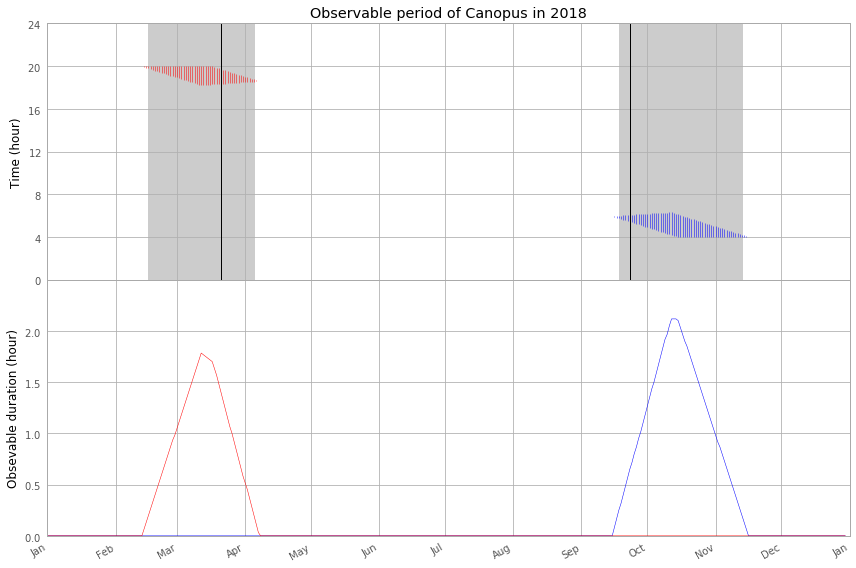

In [6]:
fig, (ax, ax1) = plt.subplots(nrows=2, figsize=(12, 8), sharex=True)
ax.vlines(obs_time.datetime, beg_time1, end_time1,
          lw=0.5, colors="b", label="Autumnal")
ax.vlines(obs_time.datetime, beg_time2, end_time2,
          lw=0.5, colors="r", label="Vernal")

# The Canopus can be observed only when the observable period is longer than 10 minutes
ax.fill_between(obs_time.datetime, 0, 24,
                 mask1, color="0.8", zorder=0)
ax.fill_between(obs_time.datetime, 0, 24,
                 mask2, color="0.8", zorder=0)

# Indicate the Vernal and Autumnal equinox
ax.vlines(Time("2018-3-21 00:00:00").datetime, 0, 24, lw=1, colors="k")
ax.vlines(Time("2018-9-23 00:00:00").datetime, 0, 24, lw=1, colors="k")

from matplotlib.ticker import MultipleLocator, FormatStrFormatter
minorLocator = MultipleLocator(1)
ax.yaxis.set_minor_locator(minorLocator)


ax.set_ylim(0, 24)
ax.set_yticks(np.arange(0, 25, 4))

ax.xaxis.set_ticks_position('both')
ax.yaxis.set_ticks_position('both')


# ax.set_xlabel("Date")
ax.set_ylabel("Time (hour)")

ax.set_title("Observable period of Canopus in 2018")

ax1.plot(obs_time.datetime, obs_dur1,
          "b", lw=0.5, label="Autumnal")
ax1.plot(obs_time.datetime, obs_dur2,
          "r", lw=0.5, label="Vernal")
ax1.set_ylabel("Obsevable duration (hour)")
ax1.set_ylim(0, 2.5)
ax1.set_yticks(np.arange(0, 2.5, 0.5))

ax1.xaxis.set_ticks_position('both')
ax1.yaxis.set_ticks_position('both')

import matplotlib.dates as mdates

months = mdates.MonthLocator()  # every month
monthsFmt = mdates.DateFormatter("%b")

# format the ticks
ax1.xaxis.set_major_locator(months)
ax1.xaxis.set_major_formatter(monthsFmt)
datemin = Time("2018-1-1 00:00:00").datetime
datemax = Time("2019-1-1 00:00:00").datetime
ax1.set_xlim(datemin, datemax)

# rotates and right aligns the x labels, and moves the bottom of the
# axes up to make room for them
fig.autofmt_xdate()

fig.tight_layout()
plt.subplots_adjust(hspace=0.)

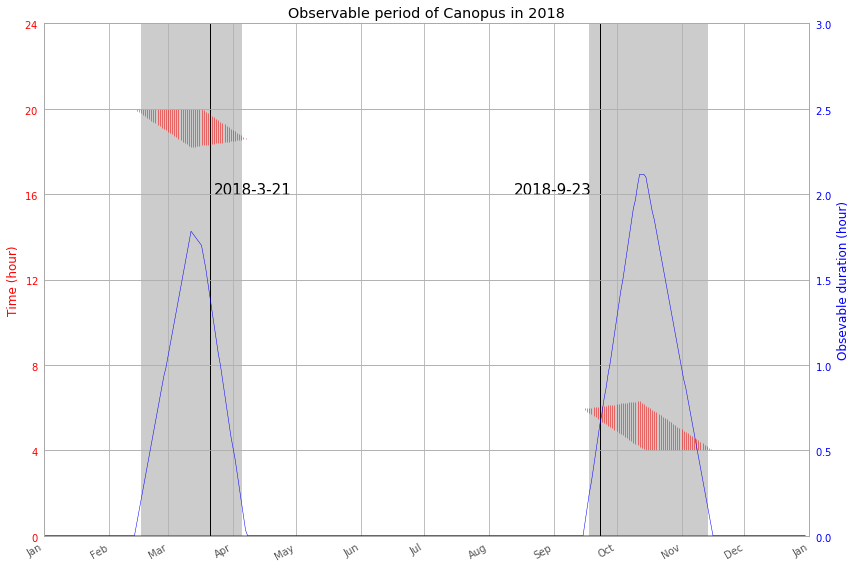

In [7]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.vlines(obs_time.datetime, beg_time1, end_time1,
          lw=0.5, colors="r", label="Autumnal")
ax.vlines(obs_time.datetime, beg_time2, end_time2,
          lw=0.5, colors="r", label="Vernal")

# The Canopus can be observed only when the observable period is longer than 10 minutes
ax.fill_between(obs_time.datetime, 0, 24,
                 mask1, color="0.8", zorder=0)
ax.fill_between(obs_time.datetime, 0, 24,
                 mask2, color="0.8", zorder=0)

# Indicate the Vernal and Autumnal equinox
ax.vlines(Time("2018-3-21 00:00:00").datetime, 0, 24, lw=1, colors="k")
ax.vlines(Time("2018-9-23 00:00:00").datetime, 0, 24, lw=1, colors="k")
ax.text(Time("2018-3-23 00:00:00").datetime, 16, "2018-3-21", fontsize=15)
ax.text(Time("2018-8-13 00:00:00").datetime, 16, "2018-9-23", fontsize=15)

# from matplotlib.ticker import MultipleLocator, FormatStrFormatter
minorLocator = MultipleLocator(1)
ax.yaxis.set_minor_locator(minorLocator)
ax.set_ylim(0, 24)
ax.set_yticks(np.arange(0, 25, 4))

ax.xaxis.set_ticks_position('both')
ax.yaxis.set_ticks_position('both')

ax.set_ylabel("Time (hour)", color="r")
ax.tick_params("y", colors="r")
ax.set_title("Observable period of Canopus in 2018")

# Add the observable duration information
ax1 = ax.twinx()
ax1.plot(obs_time.datetime, obs_dur1,
          "b", lw=0.5, label="Autumnal")
ax1.plot(obs_time.datetime, obs_dur2,
          "b", lw=0.5, label="Vernal")

# Y-axis
ax1.set_ylabel("Obsevable duration (hour)", color="b")
ax1.set_ylim(0, 3.0)
ax1.set_yticks(np.arange(0, 3.1, 0.5))
ax1.tick_params("y", colors="b")

import matplotlib.dates as mdates
months = mdates.MonthLocator()  # every month
monthsFmt = mdates.DateFormatter("%b")
ax1.xaxis.set_major_locator(months)
ax1.xaxis.set_major_formatter(monthsFmt)
datemin = Time("2018-1-1 00:00:00").datetime
datemax = Time("2019-1-1 00:00:00").datetime
ax1.set_xlim(datemin, datemax)

# rotates and right aligns the x labels, and moves the bottom of the
# axes up to make room for them
fig.autofmt_xdate()
fig.tight_layout()
plt.savefig("2018.png", dpi=100)
plt.savefig("2018.eps", dpi=100)